In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! unzip /content/gdrive/MyDrive/Food.zip

Archive:  /content/gdrive/MyDrive/Food.zip
   creating: Food/
   creating: Food/Food/
   creating: Food/Food/caesar_salad/
  inflating: Food/Food/caesar_salad/crop_caesar1.jpg  
  inflating: Food/Food/caesar_salad/crop_caesar2.jpg  
  inflating: Food/Food/caesar_salad/crop_caesar54.jpg  
  inflating: Food/Food/caesar_salad/crop_caesar66.jpg  
  inflating: Food/Food/caesar_salad/crop_caesar76.jpg  
  inflating: Food/Food/caesar_salad/crop_caesar77.jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (1).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (100).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (101).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (102).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (103).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (104).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (105).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad (107).jpg  
  inflating: Food/Food/caesar_salad/smaller_salad

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
data_path = "/content/Food/Food"  # Update with your dataset path
dataset = torchvision.datasets.ImageFolder(root=data_path, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Load the pre-trained ResNet-18 model
model = torchvision.models.resnet18(pretrained=True)
#model = torchvision.models.resnet50(pretrained=True)
num_classes = 9  # Update with the number of classes in your dataset

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a new one
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
num_epochs = 10  # Update with the desired number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Update the learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluation on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


Epoch 1/10, Loss: 1.4972243734768458
Epoch 2/10, Loss: 0.9565299074260556
Epoch 3/10, Loss: 0.7330814843275109
Epoch 4/10, Loss: 0.6514527396279939
Epoch 5/10, Loss: 0.5504278866003971
Epoch 6/10, Loss: 0.4974130215693493
Epoch 7/10, Loss: 0.4627184627615676
Epoch 8/10, Loss: 0.44343489864651037
Epoch 9/10, Loss: 0.424721109927917
Epoch 10/10, Loss: 0.41550821309186975
Test Accuracy: 87.24489795918367%


In [ ]:
# Get predictions for test data
import numpy as np
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compare the predictions with the true labels
accuracy = (predictions == true_labels).mean() * 100
print(f"Test Accuracy: {accuracy}%")

# Print the predictions and true labels
print("Predictions for the test data:")
print(predictions)
print("True labels of the test data:")
print(true_labels)


Test Accuracy: 87.24489795918367%
Predictions for the test data:
[6 6 8 4 7 6 0 2 4 6 4 4 4 4 4 4 2 8 1 4 6 6 6 8 8 6 8 2 2 8 8 4 7 6 8 6 6
 4 6 0 6 2 6 2 2 2 6 6 4 2 6 8 2 4 6 6 4 6 8 6 4 2 8 4 2 4 4 2 6 2 6 8 2 6
 3 6 2 6 6 8 4 8 4 8 6 2 2 4 4 2 3 6 2 4 6 4 2 4 2 4 6 6 8 6 8 6 4 6 8 4 2
 4 4 4 7 2 2 6 4 4 6 6 6 2 4 4 6 0 6 2 2 6 8 6 2 2 6 2 4 6 6 6 2 6 6 6 6 4
 6 6 6 2 6 4 4 2 2 6 4 8 2 6 6 2 2 4 8 4 6 8 6 2 8 4 6 4 6 6 4 8 4 4 2 6 2
 2 4 2 2 6 6 6 8 5 8 4]
True labels of the test data:
[6 6 8 4 8 6 6 2 4 6 4 4 4 4 4 4 2 8 1 4 6 6 6 8 4 6 8 2 2 7 4 4 8 6 6 6 6
 4 6 0 6 2 6 4 2 2 6 6 4 2 6 8 2 4 6 6 4 6 8 6 4 2 8 5 2 4 4 2 6 2 6 8 2 6
 3 6 2 6 6 3 4 8 2 7 6 2 2 4 4 4 3 6 2 4 6 4 2 3 2 4 6 6 8 6 8 6 4 6 8 4 2
 4 4 4 7 2 2 6 4 4 6 6 6 2 4 4 6 0 6 2 2 6 8 6 2 2 6 2 4 6 6 6 2 6 6 6 8 4
 6 6 6 2 6 8 4 2 2 6 4 8 2 6 6 2 2 8 8 5 6 7 6 2 8 4 0 4 6 6 4 7 5 4 2 6 2
 2 4 2 2 4 6 8 8 5 7 4]


Test Accuracy: 87.24489795918367%
Incorrect Predictions:
Index: 4, Predicted: 7, True Label: 8


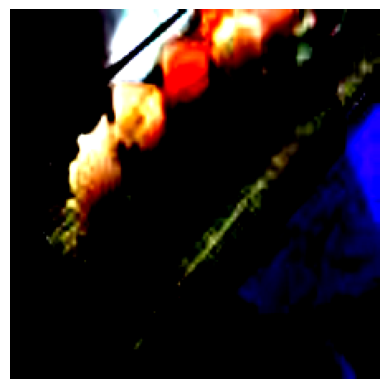

Index: 6, Predicted: 0, True Label: 6


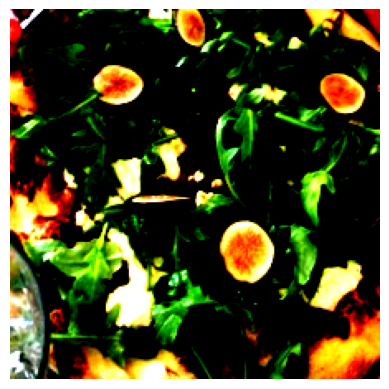

Index: 24, Predicted: 8, True Label: 4


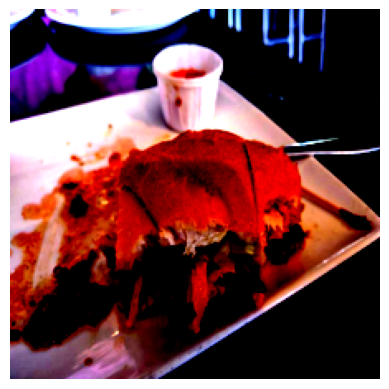

Index: 29, Predicted: 8, True Label: 7


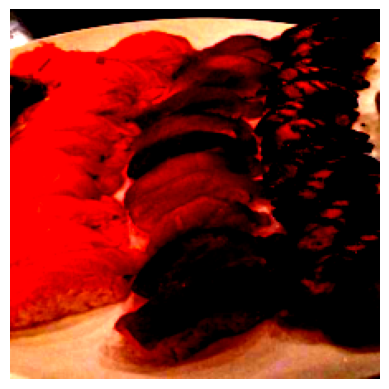

Index: 30, Predicted: 8, True Label: 4


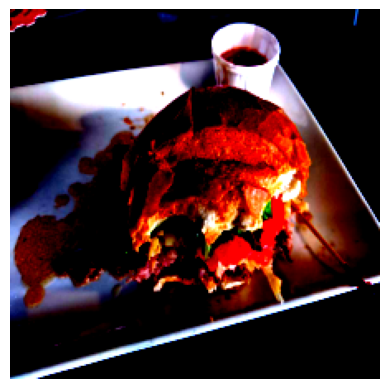

Index: 32, Predicted: 7, True Label: 8


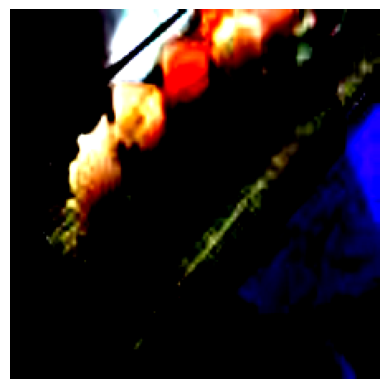

Index: 34, Predicted: 8, True Label: 6


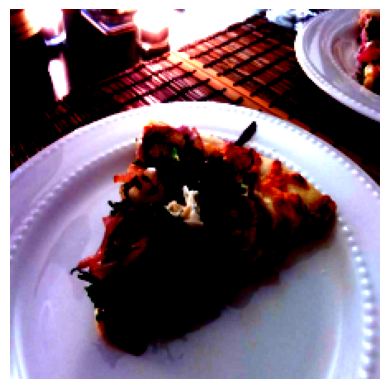

Index: 43, Predicted: 2, True Label: 4


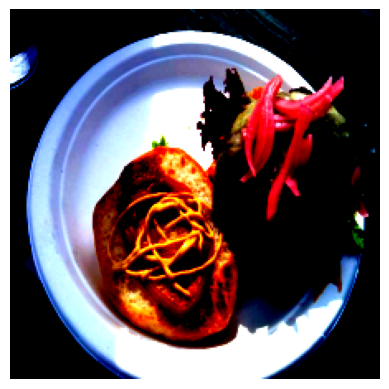

Index: 63, Predicted: 4, True Label: 5


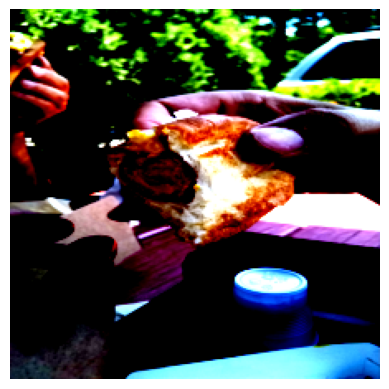

Index: 79, Predicted: 8, True Label: 3


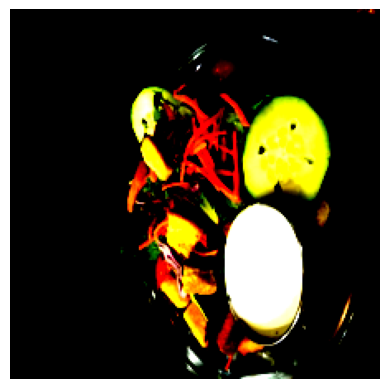

Index: 82, Predicted: 4, True Label: 2


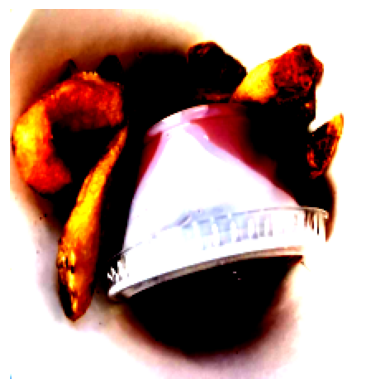

Index: 83, Predicted: 8, True Label: 7


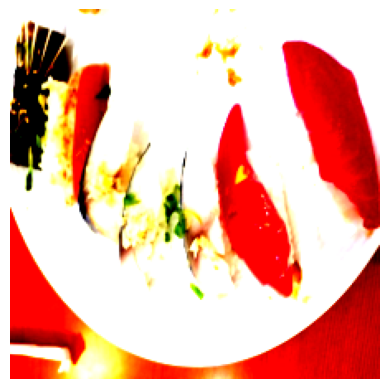

Index: 89, Predicted: 2, True Label: 4


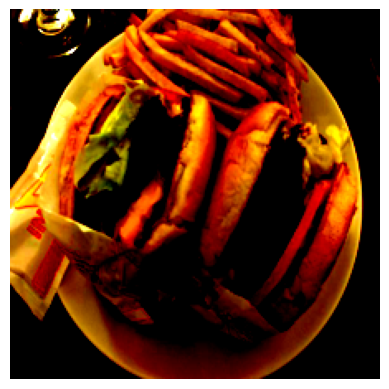

Index: 97, Predicted: 4, True Label: 3


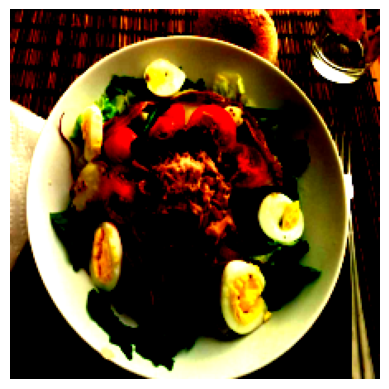

Index: 146, Predicted: 6, True Label: 8


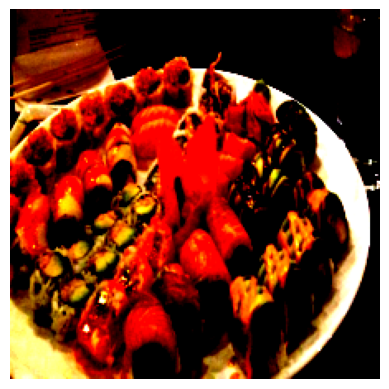

Index: 153, Predicted: 4, True Label: 8


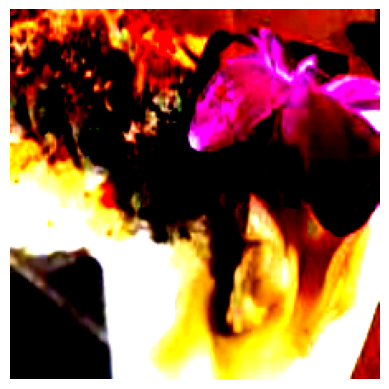

Index: 165, Predicted: 4, True Label: 8


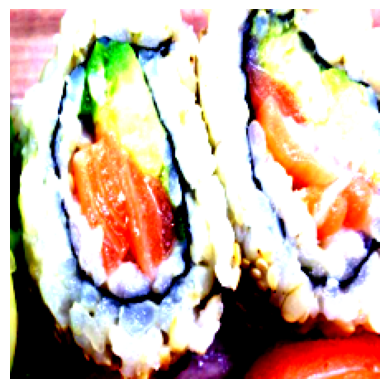

Index: 167, Predicted: 4, True Label: 5


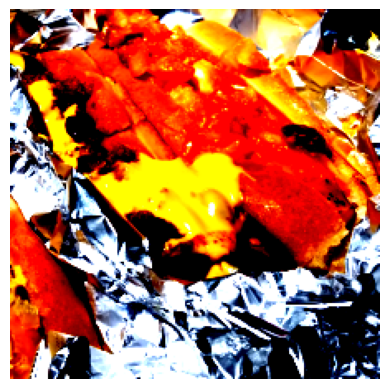

Index: 169, Predicted: 8, True Label: 7


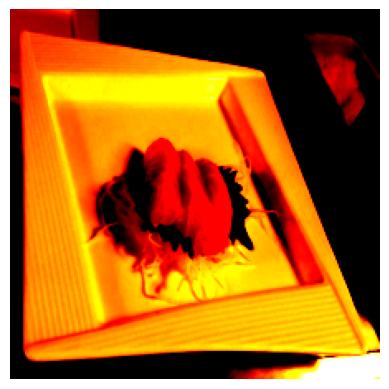

Index: 174, Predicted: 6, True Label: 0


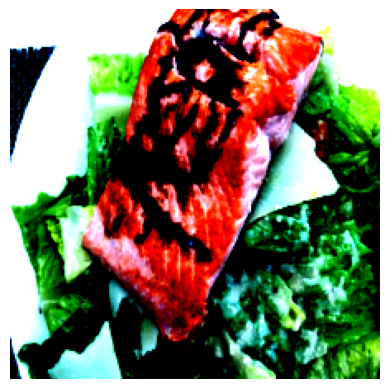

Index: 179, Predicted: 8, True Label: 7


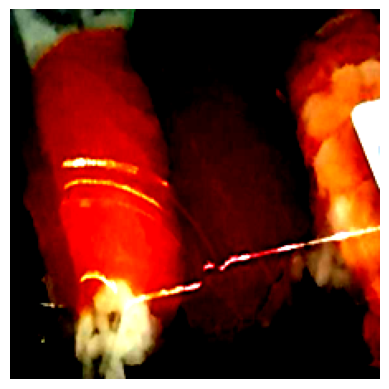

Index: 180, Predicted: 4, True Label: 5


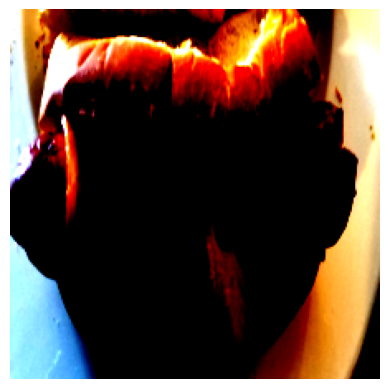

Index: 189, Predicted: 6, True Label: 4


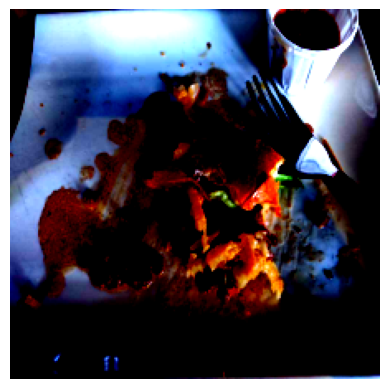

Index: 191, Predicted: 6, True Label: 8


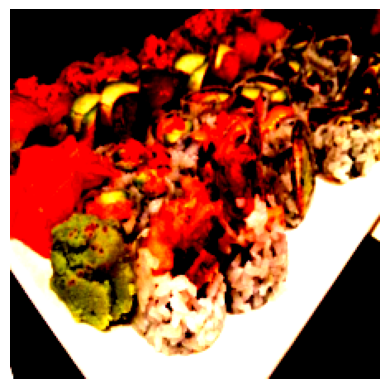

Index: 194, Predicted: 8, True Label: 7


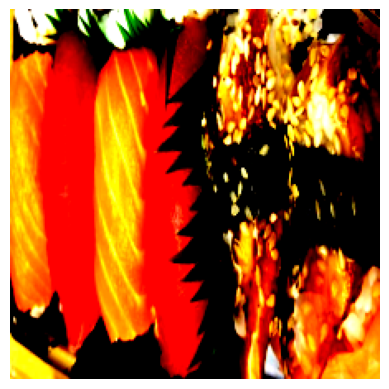

In [ ]:
import matplotlib.pyplot as plt

# Get predictions for test data
predictions = []
true_labels = []
incorrect_indices = []

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        incorrect_indices.extend(idx * batch_size + (predicted != labels).nonzero().view(-1).cpu().numpy())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compare the predictions with the true labels
accuracy = (predictions == true_labels).mean() * 100
print(f"Test Accuracy: {accuracy}%")

# Print the indices and corresponding images of the incorrect predictions
print("Incorrect Predictions:")
for idx in incorrect_indices:
    image, label = test_dataset[idx]
    print(f"Index: {idx}, Predicted: {predictions[idx]}, True Label: {true_labels[idx]}")
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [ ]:
import torchvision.models as models

# Create ResNet-18 model
model = models.resnet18(pretrained=False)

# Print the model architecture
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  